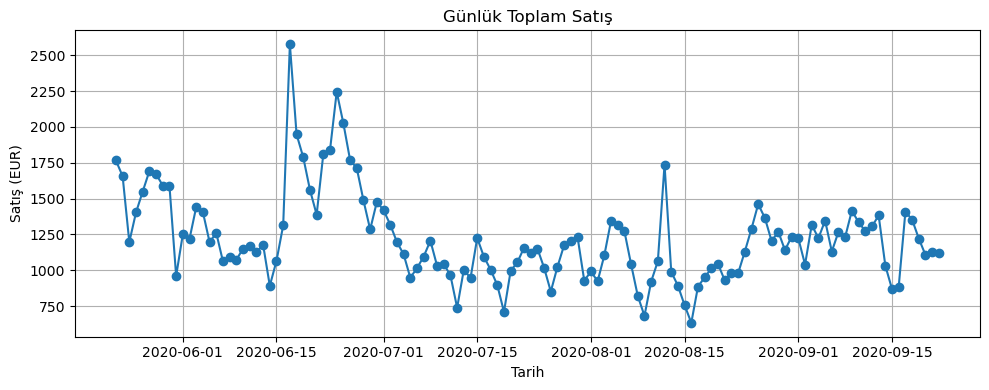


 ADF Test İstatisik -2.822168145212836
p-değeri: 0.055176313136187885
Seri durağan değil

ACF/PACF çizilemedi: too many indices for array: array is 0-dimensional, but 1 were indexed
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.73624D+00    |proj g|=  1.32758D-01

At iterate    5    f=  6.69376D+00    |proj g|=  5.55951D-02

At iterate   10    f=  6.68051D+00    |proj g|=  4.64234D-03

At iterate   15    f=  6.67719D+00    |proj g|=  3.48632D-03

At iterate   20    f=  6.67121D+00    |proj g|=  5.05788D-03


 This problem is unconstrained.



At iterate   25    f=  6.65581D+00    |proj g|=  4.73226D-02

At iterate   30    f=  6.64741D+00    |proj g|=  6.24960D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     36      1     0     0   3.358D-06   6.647D+00
  F =   6.6474065243040350     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

SARIMA Model Özeti:

                                     SARIMAX Results                                     
Dep. Variable:                             price   No. Observations:                  124
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood                -824.278
Date:  

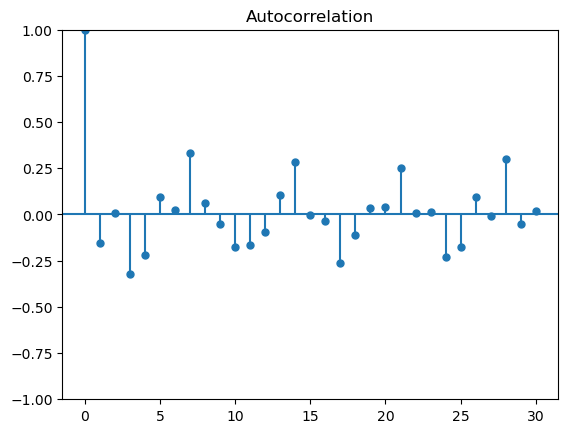

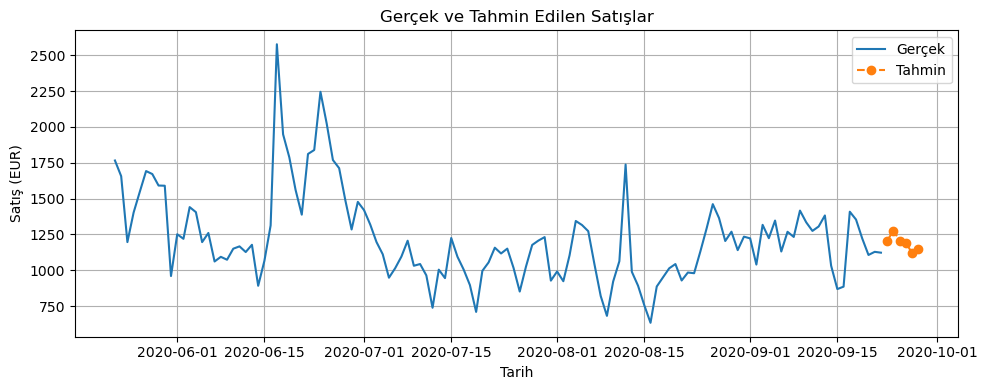

In [57]:

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv("last_4month_hm_data.csv")
df["t_dat"] = pd.to_datetime(df["t_dat"])
daily_sales = df.groupby("t_dat")["price"].sum()


plt.figure(figsize=(10, 4))
plt.plot(daily_sales, marker='o')
plt.title("Günlük Toplam Satış")
plt.xlabel("Tarih")
plt.ylabel("Satış (EUR)")
plt.grid(True)
plt.tight_layout()
plt.show()


result = adfuller(daily_sales)
print("\n ADF Test İstatisik", result[0])
print("p-değeri:", result[1])
if result[1] > 0.05:
    print("Seri durağan değil")
    diff_series = daily_sales.diff().dropna()
    d = 1
else:
    print("Seri durağan")
    diff_series = daily_sales
    d = 0


if len(diff_series) >= 10 and diff_series.std() > 1e-6:
    try:
        lags = min(30, len(diff_series) // 2)

        plot_acf(diff_series, lags=lags)
        plt.title("ACF Grafiği")
        plt.tight_layout()
        plt.show()

        plot_pacf(diff_series, lags=lags, method='ywm')
        plt.title("PACF Grafiği")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"\nACF/PACF çizilemedi: {e}")
else:
    print(f"\nACF/PACF çizimi atlandı. Yetersiz veri veya varyans çok düşük. (n={len(diff_series)}, std={diff_series.std():.6f})")


try:
    model = SARIMAX(daily_sales, order=(1, d, 1), seasonal_order=(1, 0, 1, 7))
    results = model.fit()
    print("\nSARIMA Model Özeti:\n")
    print(results.summary())
except Exception as e:
    print(f"\nModel kurulamadı: {e}")
    exit()


forecast_days = min(7, max(3, len(daily_sales) // 20))  
try:
    forecast = results.forecast(steps=forecast_days)
    print(f"\nTahmin ({forecast_days} gün):\n{forecast}")
except Exception as e:
    print(f"\ntahmin yapılamadı: {e}")
    forecast = None


plt.figure(figsize=(10, 4))
plt.plot(daily_sales, label="Gerçek")
if forecast is not None:
    plt.plot(forecast.index, forecast.values, label="Tahmin", linestyle="--", marker='o')
plt.title("Gerçek ve Tahmin Edilen Satışlar")
plt.xlabel("Tarih")
plt.ylabel("Satış (EUR)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
